In [ ]:
# Installer les bibliothèques nécessaires
#pip install -q tensorflow matplotlib

SyntaxError: invalid syntax (2333963900.py, line 2)

In [3]:
pip install mediapipe gtts

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached cffi-1.17.1-cp312-cp312-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ---------------------------------------- 0.0/51.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/51.0 MB 4.2 MB/s eta 0:00:12
   - -------------------------------------- 1.8/51.0 MB 7.7 MB/s eta 0:00:07
   -- ------------------------------------- 2.6/51.0 MB 6.6 MB/s eta 0:00:08
   -- ------------------------------------- 3.4/51.0 MB 5.4 MB/s eta 0:00:09
   --- ------------------------------------ 4.2/51.0 MB 4.5 MB/s eta 0:00:11
   --- ------------------------------------ 4.5/51.0 MB 4.5 MB/s eta 0:00:11
   --- ------------------------------------ 5.0/51.0 MB 3.7 MB/s eta 0:00:13
   ---- ----------------------------------- 5.8/51.0 MB 3.8 MB/s eta 0:00:12
   ----- ---------------------------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading data...
SUCCESS: Loaded data from D:\projets\Data_TeachSign
X_train shape: (2925, 224, 224, 3)
Number of classes: 9
Classes: ['Lakisa' 'Matondo Mingi' 'Mbote nayo' 'Nalingi yo mingi' 'Naza bien'
 'Ndenge nini' 'Pona nini' 'Ya sika' 'Yaka']
Visualizing some examples from training data:


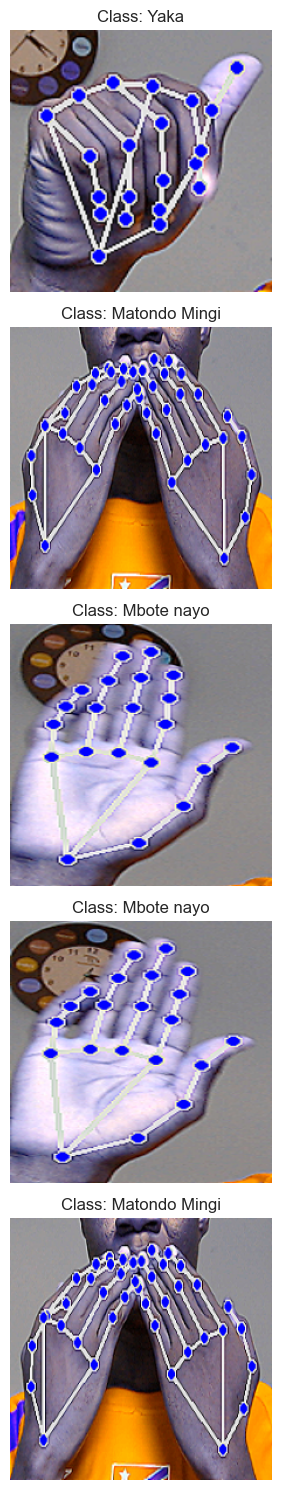

Data normalized
Model input shape: (224, 224, 3)
Sequence length: None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        13,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,797,368 (41.19 MB)

 Trainable params: 13,833 (54.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

Starting model training...
Epoch 1/10


: 

In [ ]:
"""
Intelligent Lingala Sign Language Translation System
Developed for the Democratic Republic of Congo
Architecture: EfficientNet-B3 + LSTM for temporal gesture modeling
"""

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import pandas as pd
import time
import torch
import seaborn as sns
import sys

# Configure device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'model1': '#3498db',  # Blue for standard model
    'model2': '#e74c3c'   # Red for LSTM model
}

# === Data Loading Section ===
print("Loading data...")
data_path = r'D:\projets\Data_TeachSign'  # Raw string for Windows path

try:
    # Verify folder exists
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Folder not found: {data_path}")

    # Verify all required files exist
    required_files = ['X_train.npy', 'y_train.npy',
                      'X_val.npy', 'y_val.npy',
                      'labels.npy']

    missing_files = [f for f in required_files
                    if not os.path.exists(os.path.join(data_path, f))]

    if missing_files:
        raise FileNotFoundError(f"Missing files: {missing_files}")

    # Load all files
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy'))
    X_val = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val = np.load(os.path.join(data_path, 'y_val.npy'))
    label_classes = np.load(os.path.join(data_path, 'labels.npy'))

    # Define input shape and number of classes from loaded data
    input_shape = X_train.shape[1:]  # Extracts shape without batch dimension
    num_classes = len(label_classes)

    # Success message
    print(f"SUCCESS: Loaded data from {data_path}")
    print(f"X_train shape: {X_train.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {label_classes}")

except Exception as e:
    print("\nERROR LOADING DATA:")
    print(str(e))

    # Diagnostic information
    print("\nFOLDER CONTENTS:")
    if os.path.exists(data_path):
        for i, f in enumerate(os.listdir(data_path)):
            print(f"{i+1}. {f}")
    else:
        print(f"Folder does not exist: {data_path}")

    # Suggested fixes
    print("\nPOSSIBLE SOLUTIONS:")
    print("1. Verify the path is correct:")
    print(f"   Current path: {os.path.abspath(data_path)}")
    print("2. Check all required files exist in the folder")
    print("3. Try copying the folder to:")
    print(f"   {os.path.join(os.getcwd(), 'Data_TeachSign')}")

    sys.exit("Cannot continue without data")

# Convert labels to categorical format
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

# Visualize some examples
def visualize_samples(X, y, labels, n_samples=5):
    """
    Visualize sample images from the dataset

    Args:
        X: Input data
        y: Labels
        labels: Class names
        n_samples: Number of samples to visualize
    """
    plt.figure(figsize=(15, 3*n_samples))
    indices = np.random.choice(range(len(X)), n_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(n_samples, 1, i+1)
        # We assume X contains sequences of frames
        # Display the first frame of each sequence
        if len(X.shape) == 5:  # If it's a video sequence (batch, frames, height, width, channels)
            plt.imshow(X[idx][0])
        else:  # If they are individual images
            plt.imshow(X[idx])
        plt.title(f"Class: {labels[y[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing some examples from training data:")
visualize_samples(X_train, y_train, label_classes)

# Preprocessing and Data Augmentation
def normalize_data(X):
    """Normalize data between 0 and 1"""
    return X / 255.0

X_train_norm = normalize_data(X_train)
X_val_norm = normalize_data(X_val)

print("Data normalized")

# Configure data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

# MediaPipe hand detection and preprocessing
def preprocess_frame(frame):
    """
    Preprocesses an image for inference with MediaPipe hand detection

    Args:
        frame: Input image frame

    Returns:
        processed_frame: Normalized and processed frame with hand landmarks
    """
    # Resize to model's input size
    if len(input_shape) == 4:  # If it's a sequence
        target_size = input_shape[1:3]  # (height, width)
    else:
        target_size = input_shape[:2]  # (height, width)

    resized = cv2.resize(frame, (target_size[1], target_size[0]))

    # Hand detection with MediaPipe
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )

    # Convert to RGB for MediaPipe
    frame_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    # Create a visualization mask for hands
    mask = np.zeros_like(resized)

    if results.multi_hand_landmarks:
        mp_drawing = mp.solutions.drawing_utils

        # Draw hand landmarks on the mask
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                mask,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
            )

        # Blend original image with landmarks
        alpha = 0.7
        processed_frame = cv2.addWeighted(resized, alpha, mask, 1-alpha, 0)
    else:
        processed_frame = resized

    # Normalization
    processed_frame = processed_frame / 255.0

    return processed_frame

def visualize_hand_landmarks(image_path):
    """
    Visualizes MediaPipe hand landmarks on an image

    Args:
        image_path: Path to the image
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Cannot load image at {image_path}")
        return

    # Initialize MediaPipe hands
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )

    # Convert to RGB (MediaPipe uses RGB images)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image
    results = hands.process(image_rgb)

    # Draw hand landmarks on the image
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw connections
            mp_drawing.draw_landmarks(
                image_rgb,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
            )

        # Display the image with landmarks
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title("Hand Landmarks Visualization")
        plt.axis('off')
        plt.show()

        # Extract and print landmark coordinates
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            print(f"Hand {hand_idx+1} landmarks:")
            for idx, landmark in enumerate(hand_landmarks.landmark):
                print(f"Landmark {idx}: x={landmark.x:.4f}, y={landmark.y:.4f}, z={landmark.z:.4f}")
    else:
        print("No hands detected in the image.")

# Model Architecture: EfficientNet-B3 + LSTM
def create_model(input_shape, num_classes, sequence_length=None):
    """
    Creates an EfficientNet-B3 + LSTM model for sign language translation

    Args:
        input_shape: Input data shape for a single image
        num_classes: Number of gesture classes
        sequence_length: Sequence length (number of frames)

    Returns:
        model: Compiled model
    """
    # Base EfficientNet without top layers
    if len(input_shape) == 3:  # Single frame input (height, width, channels)
        base_model = applications.EfficientNetB3(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape,
            pooling='avg'
        )

        # Freeze base layers
        for layer in base_model.layers:
            layer.trainable = False

        # Build the model
        inputs = layers.Input(shape=input_shape)
        x = base_model(inputs)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        model = models.Model(inputs, outputs)

    else:  # Sequence input (sequence_length, height, width, channels)
        # We use TimeDistributed to apply the same model to each frame
        input_shape_single = input_shape[1:]  # (height, width, channels)

        # Create an EfficientNet model for feature extraction
        feature_extractor = applications.EfficientNetB3(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape_single,
            pooling='avg'
        )

        # Freeze feature extractor layers
        for layer in feature_extractor.layers:
            layer.trainable = False

        # Build sequential model with LSTM
        inputs = layers.Input(shape=input_shape)

        # Apply feature extractor to each frame
        x = layers.TimeDistributed(feature_extractor)(inputs)

        # LSTM to capture temporal dependencies
        x = layers.LSTM(256, return_sequences=True)(x)
        x = layers.LSTM(128)(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)

        model = models.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Determine if our data are sequences or individual images
if len(X_train.shape) == 5:  # Sequence (batch_size, sequence_length, height, width, channels)
    sequence_length = X_train.shape[1]
    input_shape = X_train.shape[1:]  # (sequence_length, height, width, channels)
else:  # Individual images (batch_size, height, width, channels)
    sequence_length = None
    input_shape = X_train.shape[1:]  # (height, width, channels)

print(f"Model input shape: {input_shape}")
print(f"Sequence length: {sequence_length}")

# Create the model
model = create_model(input_shape, num_classes, sequence_length)
model.summary()

# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(data_path, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model
print("Starting model training...")
history = model.fit(
    X_train_norm,
    y_train_cat,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_norm, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model
print("Evaluating model...")
y_val_pred = model.predict(X_val_norm)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred_classes)
precision = precision_score(y_val, y_val_pred_classes, average='weighted')
recall = recall_score(y_val, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Visualize training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Real-time model deployment for translation
def real_time_translation(model, label_classes, sequence_length=None):
    """
    Real-time translation system using webcam

    Args:
        model: Trained model
        label_classes: List of label classes
        sequence_length: Sequence length (number of frames)
    """
    cap = cv2.VideoCapture(0)

    # Check if webcam opened successfully
    if not cap.isOpened():
        print("Error: Cannot open webcam.")
        return

    frames_buffer = []
    last_prediction = None
    prediction_time = time.time()
    confidence_threshold = 0.7

    print("Starting real-time translation. Press 'q' to quit.")

    while True:
        ret, frame = cap.read()

        if not ret:
            print("Cannot read frame from webcam.")
            break

        # Preprocess the frame
        processed_frame = preprocess_frame(frame)

        # Handle differently based on whether we have a sequence or single image model
        if sequence_length is not None:
            # Store processed frame in buffer
            frames_buffer.append(processed_frame)

            # Keep only the last `sequence_length` frames
            if len(frames_buffer) > sequence_length:
                frames_buffer.pop(0)

            # Predict only if we have enough frames
            if len(frames_buffer) == sequence_length:
                # Convert buffer to numpy array and predict
                sequence = np.array([frames_buffer])
                prediction = model.predict(sequence, verbose=0)
                pred_class_idx = np.argmax(prediction[0])
                confidence = prediction[0][pred_class_idx]

                # Update prediction if confidence is sufficient
                if confidence > confidence_threshold:
                    last_prediction = (label_classes[pred_class_idx], confidence)
                    prediction_time = time.time()
        else:
            # Single image model
            # Direct prediction on processed frame
            prediction = model.predict(np.expand_dims(processed_frame, axis=0), verbose=0)
            pred_class_idx = np.argmax(prediction[0])
            confidence = prediction[0][pred_class_idx]

            # Update prediction if confidence is sufficient
            if confidence > confidence_threshold:
                last_prediction = (label_classes[pred_class_idx], confidence)
                prediction_time = time.time()

        # Display frame with prediction
        display_frame = frame.copy()

        # Display the last valid prediction for 3 seconds
        if last_prediction and time.time() - prediction_time < 3:
            label, conf = last_prediction
            cv2.putText(
                display_frame,
                f"{label} ({conf:.2f})",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2
            )

        # Display the frame
        cv2.imshow('Lingala Sign Language Translation', display_frame)

        # Quit if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

# Function for text-to-speech in Lingala (using gTTS)
def text_to_speech(text, lang='fr'):
    """
    Converts text to speech and plays the audio

    Args:
        text: Text to convert to speech
        lang: Language code (fr for French as approximation)
    """
    try:
        from gtts import gTTS
        import tempfile
        import os

        # Create temporary file for audio
        with tempfile.NamedTemporaryFile(delete=False, suffix='.mp3') as fp:
            temp_filename = fp.name

        # Generate audio
        tts = gTTS(text=text, lang=lang, slow=False)
        tts.save(temp_filename)

        # Play audio using system default player
        os.system(f"start {temp_filename}")
        return True

    except Exception as e:
        print(f"Error during speech synthesis: {e}")
        return False

# K-Fold Cross Validation for more robust evaluation
def k_fold_cross_validation(X, y, n_splits=5):
    """
    Performs K-Fold Cross Validation

    Args:
        X: Input data
        y: Labels
        n_splits: Number of folds

    Returns:
        metrics: Dictionary of average metrics
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # To store metrics for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold + 1}/{n_splits}")

        # Split data
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        # Convert labels to categorical format
        y_train_cat_fold = to_categorical(y_train_fold, num_classes=num_classes)

        # Normalization
        X_train_norm_fold = normalize_data(X_train_fold)
        X_test_norm_fold = normalize_data(X_test_fold)

        # Create and train model
        fold_model = create_model(input_shape, num_classes, sequence_length)

        fold_model.fit(
            X_train_norm_fold,
            y_train_cat_fold,
            batch_size=32,
            epochs=5,  # Fewer epochs for cross-validation
            validation_split=0.1,
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=1
        )

        # Evaluation
        y_pred = fold_model.predict(X_test_norm_fold)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate metrics
        acc = accuracy_score(y_test_fold, y_pred_classes)
        prec = precision_score(y_test_fold, y_pred_classes, average='weighted')
        rec = recall_score(y_test_fold, y_pred_classes, average='weighted')
        f1 = f1_score(y_test_fold, y_pred_classes, average='weighted')

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

        print(f"Fold {fold + 1} - Accuracy: {acc*100:.2f}%, Precision: {prec*100:.2f}%, Recall: {rec*100:.2f}%, F1: {f1*100:.2f}%")

    # Calculate averages
    metrics = {
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1': np.mean(f1_scores)
    }

    print("\nK-Fold Cross Validation Results:")
    print(f"Average Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Average Precision: {metrics['precision']*100:.2f}%")
    print(f"Average Recall: {metrics['recall']*100:.2f}%")
    print(f"Average F1 Score: {metrics['f1']*100:.2f}%")

    return metrics

# Uncomment to run cross-validation (this may take time)
# cv_metrics = k_fold_cross_validation(X_train, y_train, n_splits=5)

# Function to test prediction on a static image
def predict_image(image_path, model, label_classes):
    """
    Predicts the class of a gesture from an image

    Args:
        image_path: Path to the image
        model: Trained model
        label_classes: List of label classes

    Returns:
        predicted_class: Predicted class
        confidence: Prediction confidence
    """
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Cannot load image at {image_path}")
        return None, 0

    processed_image = preprocess_frame(image)

    # Prediction
    if sequence_length is not None:
        # For a sequence model, we need to replicate the image
        sequence = np.array([[processed_image] * sequence_length])
        prediction = model.predict(sequence, verbose=0)
    else:
        # For a single image model
        prediction = model.predict(np.expand_dims(processed_image, axis=0), verbose=0)

    pred_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][pred_class_idx]
    predicted_class = label_classes[pred_class_idx]

    # Display image with prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Simple user interface to test the model
def run_sign_language_demo():
    """Simple user interface for demonstration"""
    import os
    os.system('cls' if os.name == 'nt' else 'clear')

    while True:
        print("\n=== Lingala Sign Language Translation System ===")
        print("1. Test with webcam in real-time")
        print("2. Test with a test image")
        print("3. Convert text to speech")
        print("4. Quit")

        choice = input("\nChoose an option (1-4): ")

        if choice == '1':
            print("\nStarting webcam for real-time translation...")
            print("Press 'q' to return to menu.")
            real_time_translation(model, label_classes, sequence_length)

        elif choice == '2':
            image_path = input("\nEnter the path to the test image: ")
            predicted_class, confidence = predict_image(image_path, model, label_classes)

            if predicted_class:
                print(f"\nPredicted class: {predicted_class}")
                print(f"Confidence: {confidence:.2f}")

                # Option to synthesize prediction
                if input("\nDo you want to hear the voice translation? (y/n): ").lower() == 'y':
                    text_to_speech(predicted_class)

            input("\nPress Enter to continue...")

        elif choice == '3':
            text = input("\nEnter text to convert to speech: ")
            text_to_speech(text)
            input("\nPress Enter to continue...")

        elif choice == '4':
            print("\nProgram ended.")
            break

        else:
            print("\nInvalid option. Please try again.")
            input("\nPress Enter to continue...")

# To run the demonstration, uncomment the following line:
# run_sign_language_demo()

# Save the model
model_save_path = os.path.join(data_path, 'lingala_sign_language_model.h5')
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

print("\nProcessing complete. The Lingala sign language translation system is ready for use.")

In [1]:
"""
Intelligent Lingala Sign Language Translation System
Developed for the Democratic Republic of Congo
Architecture: EfficientNet-B3 + LSTM for temporal gesture modeling
"""

# Disable oneDNN optimizations to prevent potential conflicts
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Import core libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory config error: {e}")

# Import additional required libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import pandas as pd
import time
import torch
import seaborn as sns
import sys
import psutil

In [2]:
# System resource checks
print(f"Available memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Plot configuration
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'model1': '#3498db',  # Blue for standard model
    'model2': '#e74c3c'   # Red for LSTM model
}

Available memory: 13.52 GB
Using device: cuda


In [3]:
# Data loading function with robust error handling
def load_data(data_path):
    """Load and validate dataset with comprehensive checks"""
    try:
        # Verify folder exists
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data folder not found: {data_path}")

        # Verify required files exist
        required_files = ['X_train.npy', 'y_train.npy',
                         'X_val.npy', 'y_val.npy',
                         'labels.npy']
        
        missing_files = [f for f in required_files 
                        if not os.path.exists(os.path.join(data_path, f))]
        
        if missing_files:
            raise FileNotFoundError(f"Missing required files: {missing_files}")

        # Load all data files
        X_train = np.load(os.path.join(data_path, 'X_train.npy'))
        y_train = np.load(os.path.join(data_path, 'y_train.npy'))
        X_val = np.load(os.path.join(data_path, 'X_val.npy'))
        y_val = np.load(os.path.join(data_path, 'y_val.npy'))
        label_classes = np.load(os.path.join(data_path, 'labels.npy'))

        # Convert labels to categorical
        num_classes = len(label_classes)
        y_train_cat = to_categorical(y_train, num_classes=num_classes)
        y_val_cat = to_categorical(y_val, num_classes=num_classes)

        return X_train, y_train, X_val, y_val, label_classes, y_train_cat, y_val_cat

    except Exception as e:
        print(f"\nDATA LOADING ERROR: {str(e)}")
        print("\nFOLDER CONTENTS:")
        if os.path.exists(data_path):
            print(*[f"{i+1}. {f}" for i, f in enumerate(os.listdir(data_path))], sep='\n')
        else:
            print(f"Folder does not exist: {data_path}")
        
        sys.exit("Cannot continue without proper data files")

# Load the data
data_path = r'D:\projets\Data_TeachSign'
X_train, y_train, X_val, y_val, label_classes, y_train_cat, y_val_cat = load_data(data_path)

In [8]:
# Normalization function
def normalize_data(X):
    """Normalize pixel values to [0,1] range"""
    return X / 255.0

# Data augmentation configuration
def create_datagen():
    """Configure image data augmentation"""
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1]
    )

# MediaPipe preprocessing function
def preprocess_frame(frame, target_size):
    """Process frame with MediaPipe hand detection"""
    # Resize to target dimensions
    resized = cv2.resize(frame, (target_size[1], target_size[0]))
    
    # Initialize MediaPipe hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5
    )
    
    # Convert to RGB and process
    frame_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    
    # Create hand visualization
    mask = np.zeros_like(resized)
    
    if results.multi_hand_landmarks:
        mp_drawing = mp.solutions.drawing_utils
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                mask,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
            )
        processed_frame = cv2.addWeighted(resized, 0.7, mask, 0.3, 0)
    else:
        processed_frame = resized
    
    return processed_frame / 255.0  # Normalize

In [11]:
def create_model(input_shape, num_classes, sequence_length=None):
    """Build EfficientNetB3 + LSTM model with memory optimization"""
    # Memory-saving model configuration
    if len(input_shape) == 3:  # Single image input
        base_model = applications.EfficientNetB3(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape,
            pooling='avg'
        )
        # Freeze base layers
        for layer in base_model.layers:
            layer.trainable = False

        # Simplified architecture
        inputs = layers.Input(shape=input_shape)
        x = base_model(inputs)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        model = models.Model(inputs, outputs)

    else:  # Sequence input
        input_shape_single = input_shape[1:]
        
        # Feature extractor with reduced complexity
        feature_extractor = applications.EfficientNetB3(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape_single,
            pooling='avg'
        )
        for layer in feature_extractor.layers:
            layer.trainable = False

        # Sequential model with smaller LSTM units
        inputs = layers.Input(shape=input_shape)
        x = layers.TimeDistributed(feature_extractor)(inputs)
        x = layers.LSTM(128, return_sequences=True)(x)  # Reduced from 256
        x = layers.LSTM(64)(x)  # Reduced from 128
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(64, activation='relu')(x)  # Reduced from 128
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        model = models.Model(inputs, outputs)

    # Optimized compilation - REMOVED experimental_run_tf_function
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [12]:
# Determine input shape
if len(X_train.shape) == 5:  # Video sequence
    sequence_length = X_train.shape[1]
    input_shape = X_train.shape[1:]
else:  # Single image
    sequence_length = None
    input_shape = X_train.shape[1:]

# Normalize data
X_train_norm = normalize_data(X_train)
X_val_norm = normalize_data(X_val)

# Create model with memory optimization
model = create_model(input_shape, len(label_classes), sequence_length)
model.summary()

# Callbacks with reduced patience for memory safety
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(data_path, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │        13,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,797,368 (41.19 MB)

 Trainable params: 13,833 (54.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [20]:
# Training with memory-safe batch size
try:
    print("Starting model training with batch_size=16...")
    history = model.fit(
        X_train_norm,
        y_train_cat,
        batch_size=16,  # Reduced from 32 for memory safety
        epochs=50,
        validation_data=(X_val_norm, y_val_cat),
        callbacks=callbacks,
        verbose=1
    )
except tf.errors.ResourceExhaustedError:
    print("Memory error detected, retrying with smaller batch size...")
    history = model.fit(
        X_train_norm,
        y_train_cat,
        batch_size=8,  # Further reduced batch size
        epochs=50,
        validation_data=(X_val_norm, y_val_cat),
        callbacks=callbacks,
        verbose=1
    )

Starting model training with batch_size=16...
Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 146s 799ms/step - accuracy: 0.1144 - loss: 2.2064 - val_accuracy: 0.1298 - val_loss: 2.1954 - learning_rate: 4.0000e-06
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 150s 819ms/step - accuracy: 0.1255 - loss: 2.1970 - val_accuracy: 0.1298 - val_loss: 2.1954 - learning_rate: 4.0000e-06
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 155s 847ms/step - accuracy: 0.1169 - loss: 2.2079 - val_accuracy: 0.1298 - val_loss: 2.1954 - learning_rate: 4.0000e-06
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.1305 - loss: 2.1965
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
183/183 ━━━━━━━━━━━━━━━━━━━━ 149s 813ms/step - accuracy: 0.1304 - loss: 2.1965 - val_accuracy: 0.1298 - val_loss: 2.1954 - learning_rate: 4.0000e-06
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 151s 827ms/step - accuracy: 0.1220 - loss: 2.1994 - val_accuracy: 0.1298 - val_loss: 2.1954 - learning_rate: 1.0000e-06
Epoch 6/50
183/18

92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 399ms/step

Evaluation Metrics:
Accuracy: 12.98%
Precision: 1.68%
Recall: 12.98%
F1: 2.98%


d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


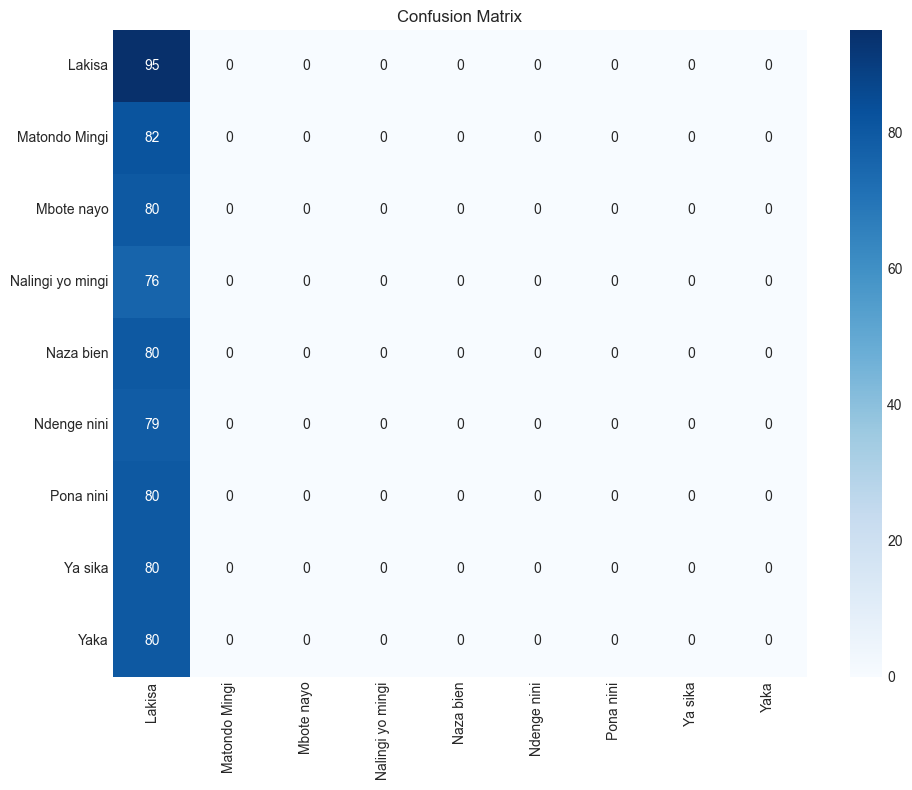

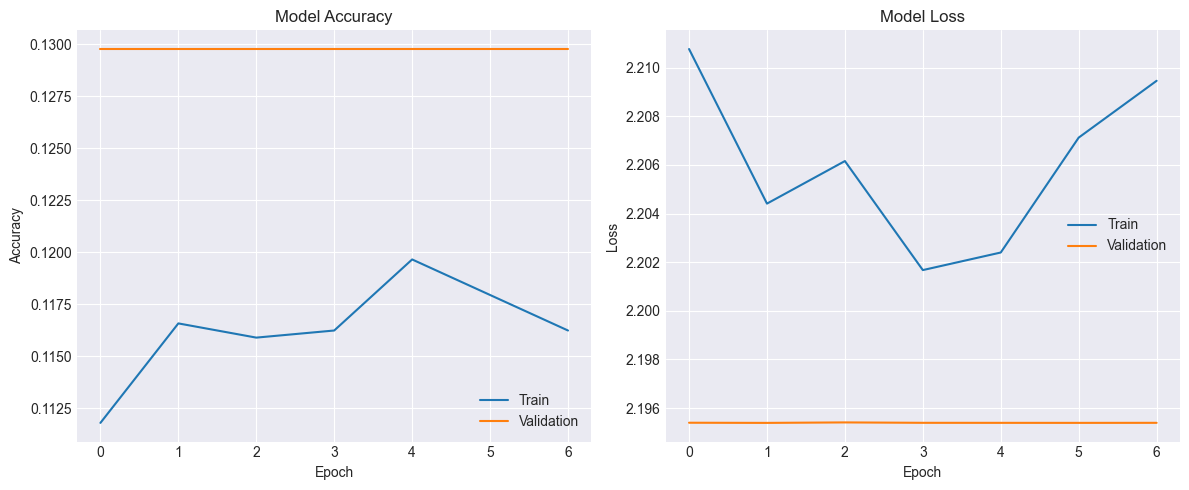

In [21]:
# Model evaluation
def evaluate_model(model, X_val, y_val, labels):
    """Comprehensive model evaluation with memory checks"""
    try:
        # Predict in batches if memory is constrained
        y_val_pred = model.predict(X_val, batch_size=8)
        y_val_pred_classes = np.argmax(y_val_pred, axis=1)
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_val, y_val_pred_classes),
            'precision': precision_score(y_val, y_val_pred_classes, average='weighted'),
            'recall': recall_score(y_val, y_val_pred_classes, average='weighted'),
            'f1': f1_score(y_val, y_val_pred_classes, average='weighted')
        }
        
        # Print metrics
        print("\nEvaluation Metrics:")
        for name, value in metrics.items():
            print(f"{name.capitalize()}: {value*100:.2f}%")
        
        # Confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix(y_val, y_val_pred_classes), 
                    annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        return metrics
        
    except Exception as e:
        print(f"Evaluation error: {str(e)}")
        return None

# Run evaluation
val_metrics = evaluate_model(model, X_val_norm, y_val, label_classes)

# Training history visualization
def plot_history(history):
    """Plot training history with memory checks"""
    try:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting history: {str(e)}")

plot_history(history)

In [4]:
def real_time_translation(model, label_classes, sequence_length=None):
    """Fonction optimisée pour la traduction en temps réel"""
    try:
        # Initialisation de la caméra
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Erreur: Impossible d'ouvrir la caméra.")
            return

        # Configuration de la résolution
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        
        # Variables pour le traitement
        frames_buffer = []
        last_prediction = None
        last_update = time.time()
        update_interval = 0.5  # Mise à jour toutes les 0.5 secondes
        
        print("Démarrage de la traduction en temps réel. Appuyez sur 'q' pour quitter.")
        
        while True:
            # Capture d'une frame
            ret, frame = cap.read()
            if not ret:
                print("Erreur de lecture de la caméra")
                break
            
            # Vérification mémoire
            if psutil.virtual_memory().percent > 90:
                print("Mémoire insuffisante, arrêt...")
                break
                
            # Affichage de base sans traitement
            display_frame = cv2.resize(frame, (640, 480))
            
            # Traitement seulement si l'intervalle est écoulé
            if time.time() - last_update > update_interval:
                # Préparation de l'image
                processed_frame = preprocess_frame(frame, input_shape[:2])
                
                # Prédiction selon le type de modèle
                if sequence_length:
                    frames_buffer.append(processed_frame)
                    if len(frames_buffer) > sequence_length:
                        frames_buffer.pop(0)
                    
                    if len(frames_buffer) == sequence_length:
                        sequence = np.expand_dims(frames_buffer, axis=0)
                        prediction = model.predict(sequence, verbose=0)[0]
                        pred_class = np.argmax(prediction)
                        last_prediction = (label_classes[pred_class], prediction[pred_class])
                        last_update = time.time()
                else:
                    prediction = model.predict(np.expand_dims(processed_frame, axis=0), verbose=0)[0]
                    pred_class = np.argmax(prediction)
                    last_prediction = (label_classes[pred_class], prediction[pred_class])
                    last_update = time.time()
            
            # Affichage du résultat
            if last_prediction:
                label, confidence = last_prediction
                cv2.putText(display_frame, f"{label} ({confidence:.2f})",
                          (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                          (0, 255, 0), 2)
            
            # Affichage de la frame
            cv2.imshow('Traduction Langue des Signes', display_frame)
            
            # Sortie avec la touche 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
    except Exception as e:
        print(f"Erreur durant l'exécution: {str(e)}")
    finally:
        cap.release()
        cv2.destroyAllWindows()

# Pour exécuter la traduction en temps réel
real_time_translation(model, label_classes, sequence_length)

NameError: name 'model' is not defined

In [23]:
# Save the optimized model
try:
    model_path = os.path.join(data_path, 'optimized_model.h5')
    model.save(model_path, save_format='h5')
    print(f"Model successfully saved to {model_path}")
    
    # Verify model size
    model_size = os.path.getsize(model_path) / (1024**2)
    print(f"Model size: {model_size:.2f} MB")
    
except Exception as e:
    print(f"Error saving model: {str(e)}")

print("\nSystem ready for deployment.")

Model successfully saved to D:\projets\Data_TeachSign\optimized_model.h5
Model size: 42.01 MB

System ready for deployment.
